In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
scores_data = pd.read_csv('../data/NFL_historical/spreadspoke_scores.csv')
team_names=scores_data['team_home'].unique()
print(team_names)
print('\n Data could be cleaned up if you wanted to combine Football Team and Commanders for example')
victory=scores_data.score_home>scores_data.score_away

features_full=scores_data.copy()[['schedule_season', 'team_home', 'team_away']]
y_full=victory
features_full


['Miami Dolphins' 'Houston Oilers' 'San Diego Chargers'
 'Green Bay Packers' 'Atlanta Falcons' 'Buffalo Bills' 'Detroit Lions'
 'Pittsburgh Steelers' 'San Francisco 49ers' 'St. Louis Cardinals'
 'Washington Redskins' 'Los Angeles Rams' 'Cleveland Browns'
 'Dallas Cowboys' 'Denver Broncos' 'Minnesota Vikings' 'New York Jets'
 'Oakland Raiders' 'Philadelphia Eagles' 'Baltimore Colts'
 'Boston Patriots' 'Kansas City Chiefs' 'New York Giants' 'Chicago Bears'
 'New Orleans Saints' 'Cincinnati Bengals' 'New England Patriots'
 'Seattle Seahawks' 'Tampa Bay Buccaneers' 'Los Angeles Raiders'
 'Indianapolis Colts' 'Phoenix Cardinals' 'Arizona Cardinals'
 'Jacksonville Jaguars' 'St. Louis Rams' 'Carolina Panthers'
 'Baltimore Ravens' 'Tennessee Oilers' 'Tennessee Titans' 'Houston Texans'
 'Los Angeles Chargers' 'Washington Football Team' 'Las Vegas Raiders'
 'Washington Commanders']

 Data could be cleaned up if you wanted to combine Football Team and Commanders for example


,schedule_season,team_home,team_away
0,1966,Miami Dolphins,Oakland Raiders
1,1966,Houston Oilers,Denver Broncos
2,1966,San Diego Chargers,Buffalo Bills
3,1966,Miami Dolphins,New York Jets
4,1966,Green Bay Packers,Baltimore Colts
...,...,...,...
13511,2022,Buffalo Bills,Cincinnati Bengals
13512,2022,San Francisco 49ers,Dallas Cowboys
13513,2022,Kansas City Chiefs,Cincinnati Bengals
13514,2022,Philadelphia Eagles,San Francisco 49ers


In [3]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# Fit the encoder on the team names and transform them into indices
team_indices = label_encoder.fit_transform(team_names)
# Print the mapping of team names to indices

#for now, just look at recent years. In future, maybe make this work by year with like an LSTM or RNN remembering year
features=features_full[features_full.schedule_season>2019]
y=np.array(y_full[features_full.schedule_season>2019])
# print(y)
home_team_idx=label_encoder.transform(features['team_home'])
away_team_idx=label_encoder.transform(features['team_away'])
# print(len(home_team_idx))
# print(len(away_team_idx))
X_full = np.array([home_team_idx, away_team_idx]).T

#split training and test data
X_trainval, X_test, y_trainval, y_test = train_test_split(
                X_full, y, test_size=0.2, random_state=42)

X_trainval


array([[17, 10],
       [38, 26],
       [ 8,  3],
       ...,
       [ 1, 30],
       [12,  7],
       [40, 32]])

2023-08-03 07:45:08.547364: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 10: loss = 0.6765403151512146, val_loss = 0.6829148530960083
Epoch 10: loss = 0.6623319387435913, val_loss = 0.6703410148620605
Epoch 10: loss = 0.6532233357429504, val_loss = 0.6533845663070679
Epoch 10: loss = 0.6421645283699036, val_loss = 0.6519331932067871
Epoch 10: loss = 0.6399176716804504, val_loss = 0.6262428760528564


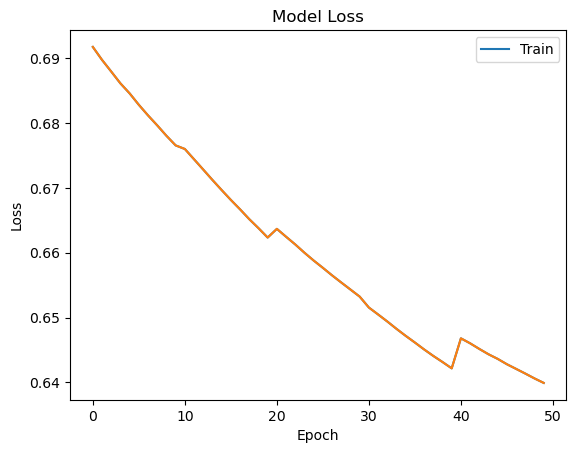

In [4]:
def custom_loss(y_true, y_pred):
    y1, y2 = y_pred[:, 0], y_pred[:, 1]
    prob = victory_prob(y1, y2)  # Assuming victory_prob is defined
    y_true = tf.squeeze(y_true)
    return tf.keras.losses.binary_crossentropy(y_true, prob)

def victory_prob(y1,y2):
    #close to 1 if team 1 is way better, 0 if 2 is way better, 0.5 if even. sounds like sigmoid
    return tf.keras.activations.sigmoid(y1-y2)

number_of_teams = len(team_names)  # Assuming 32 NFL teams

# Define inputs for the two teams in each game
input_team1 = tf.keras.layers.Input(shape=(), dtype='int32')
input_team2 = tf.keras.layers.Input(shape=(), dtype='int32')

# Embedding layer to represent team ratings
embedding_layer = tf.keras.layers.Embedding(number_of_teams, 1, input_length=1)

# Extract ratings for the two teams
team1_rating = tf.keras.layers.Flatten()(embedding_layer(input_team1))
team2_rating = tf.keras.layers.Flatten()(embedding_layer(input_team2))

# Concatenate the ratings
ratings = tf.keras.layers.Concatenate(axis=-1)([team1_rating, team2_rating])

# Define the model
model = tf.keras.models.Model(inputs=[input_team1, input_team2], outputs=ratings)

# Compile the model with custom loss
model.compile(optimizer='adam', loss=custom_loss)

# Training
from tensorflow.keras.callbacks import Callback

class PrintEveryXEpochs(Callback):
    def __init__(self, print_interval):
        super().__init__()
        self.print_interval = print_interval
        
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.print_interval == 0:
            print(f'Epoch {epoch+1}: loss = {logs["loss"]}, val_loss = {logs["val_loss"]}')
            
            
from sklearn.model_selection import KFold
kf = KFold(n_splits=5) # Number of folds
loss_values = []
val_loss= []
for train_index, val_index in kf.split(X_trainval):
    X_train, X_val = X_trainval[train_index], X_trainval[val_index]
    y_train, y_val = y_trainval[train_index], y_trainval[val_index]

    # Define the model here as before
    print_interval = 10 # number of epochs per print interval
    callbacks = [PrintEveryXEpochs(print_interval)]
    history=model.fit(x=[X_train[:, 0], X_train[:, 1]], y=y_train,
              validation_data=([X_val[:, 0], X_val[:, 1]], y_val),
              epochs=10,callbacks=callbacks,verbose=0)
    loss_values += history.history['loss']
    val_loss += history.history['val_loss']
plt.plot(loss_values,label='loss')
plt.plot(loss_values,label='val_loss')
plt.title('Model Loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

# Extract Team Ratings
team_ratings = embedding_layer.get_weights()[0]


In [5]:

team_indices = range(len(team_names))
# Inverse transform to get the team names
team_names = label_encoder.inverse_transform(team_indices)
data = list(zip(team_names, np.squeeze(team_ratings)))
df = pd.DataFrame(data, columns=['Team Name', 'Rating'])
df = df.sort_values('Rating', ascending=False)

def odds_of_winning(team1,team2):
    return float(victory_prob(df.loc[df['Team Name'] == team1, 'Rating'].values[0],
                   df.loc[df['Team Name'] == team2, 'Rating'].values[0]))
print(odds_of_winning('Kansas City Chiefs','Denver Broncos'))
print(odds_of_winning('Kansas City Chiefs','New York Jets'))
df


0.6480764150619507
0.7038143873214722


,Team Name,Rating
18,Kansas City Chiefs,0.423451
5,Buffalo Bills,0.390322
13,Green Bay Packers,0.355701
38,Tampa Bay Buccaneers,0.273169
40,Tennessee Titans,0.210986
32,Pittsburgh Steelers,0.204807
26,New Orleans Saints,0.191182
8,Cincinnati Bengals,0.169675
22,Los Angeles Rams,0.166556
10,Dallas Cowboys,0.159339


In [6]:
#might consider doing a separate model for each year, perhaps combining batches of 2-3 years or 
#taking a weighted average or learning the weights